# Richter's Predictor: Modeling Earthquake Damage. Top 5% Solution

https://www.drivendata.org/competitions/57/nepal-earthquake/


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import StratifiedKFold,RandomizedSearchCV, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import KBinsDiscretizer

from xgboost import XGBClassifier
from scipy.stats import boxcox_normmax
from scipy.special import boxcox1p

In [48]:
# Read In Files
y_train = pd.read_csv('train_labels.csv')
X_train = pd.read_csv('train_values.csv')
X_test = pd.read_csv('test_values.csv')
submission = pd.read_csv('submission_format.csv')

## Data Cleaning

In [49]:
# Drop ID from train_labels
y_train = y_train.drop('building_id', axis=1)
y_train.head()

,damage_grade
0,3
1,2
2,3
3,2
4,3


<Figure size 576x504 with 0 Axes>

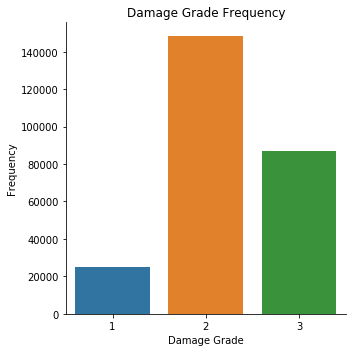

In [50]:
plt.figure(figsize = (8,7))
sns.catplot(data=y_train, kind='count', x='damage_grade')
plt.xlabel('Damage Grade')
plt.ylabel('Frequency')
plt.title('Damage Grade Frequency')
plt.tight_layout()

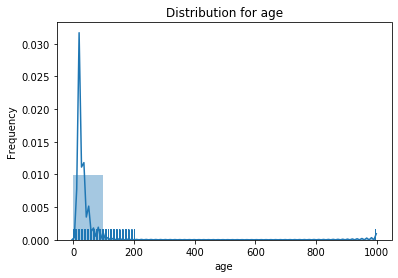

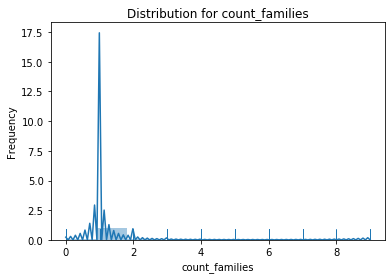

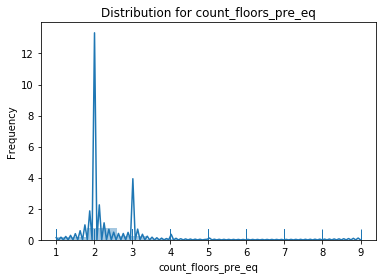

In [51]:
cols = ['age', 'count_families', 'count_floors_pre_eq']

def histplot(df, column, hist = False):
    for col in column:
        sns.histplot(df[col], rug=True, hist=hist)
        plt.title('Distribution for ' + col)
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.show()

histplot(X_train, cols, hist= True)

From the above charts we can see that there are obvious outliers in these features that can be removed.
- age: Remove any values with 995 which accounts for 1390 obervations.
- count_families: Remove buildings with 6 or more families
- count_floors_pre_eq: Remove buildings with 6 or more floors

In [52]:
# Remove outliers for both values and labels
X_train = pd.concat([X_train, y_train], sort=False, axis=1)
X_train = X_train[X_train['age'] < 995]
X_train = X_train[X_train['count_families'] < 6]
X_train = X_train[X_train['count_floors_pre_eq'] < 6]
X_train['age'].value_counts().sort_index()

0      25998
5      33658
10     38864
15     35982
20     32165
25     24356
30     18020
35     10707
40     10551
45      4708
50      7249
55      2031
60      3609
65      1118
70      1973
75       511
80      3043
85       838
90      1077
95       413
100     1336
105       89
110      100
115       21
120      174
125       37
130        9
135        5
140        8
145        3
150      142
155        1
160        6
165        2
170        6
175        5
180        7
185        1
190        3
195        2
200      105
Name: age, dtype: int64

## Geo_level Features

### Description
geo_level_1_id, geo_level_2_id, geo_level_3_id (type: int): geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.

The level 1 feature has a relatively small number of unique values which can be handled with dummy variable, but level 2 and 3 has a huge number of unique values which are harder to manage.

### Target Encoding
To make these columns usable we will use target encoding. Target encoding involves working out the mean of the target variable for each unique value.

The categorical feature therefore becomes numerical and therefore useable for our model.

Target encoding can cause overfitting when the number of values used is low. Luckily we have a large dataset with about of values.
To avoid this, we have used additive smoothing.

The averages are worked out at this point when y_train is part of the X_train dataset and then mapped later in the preprocessing stages.

See https://maxhalford.github.io/blog/target-encoding/ for more information on this approach.



In [53]:
#compute mean och geo_level_2 and geo_level_3

# To avoid overfitting, we use additive smoothing 

def calc_smooth_mean(df, by, on, m):
    
    # Compute the global mean
    mean = df[on].mean()
    
    #compute the number of values and the mean of each group
    agg = df.groupby(by)[on].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    
    #Compute the smoothed mean
    smooth = (counts * means + m * means) / (counts + m)
    smooth_means = pd.Series(smooth, agg.index)
    
    return smooth_means
smooth_geo_level_3_means = calc_smooth_mean(X_train, by='geo_level_3_id', on='damage_grade', m=300) 
smooth_geo_level_2_means = calc_smooth_mean(X_train, by='geo_level_2_id', on='damage_grade', m=300)
smooth_geo_level_3_means

geo_level_3_id
0        3.000000
1        2.500000
3        1.888889
5        1.142857
6        2.523810
           ...   
12562    2.000000
12563    2.041667
12564    2.000000
12565    1.285714
12567    2.000000
Length: 11581, dtype: float64

In [54]:
# Adding an identification column so we can resplit X_train, X_test later.
y_train = X_train['damage_grade']
X_train['type'] = 1
X_test['type'] = 0

X = pd.concat([X_train, X_test], sort=False)
X = X.drop('damage_grade', axis=1)

## Preprocessing

In [55]:
# Change numerical features that are categorical
cols = ['geo_level_1_id','count_families', 'count_floors_pre_eq']
X[cols] = X[cols].astype('category')

In [56]:
# Map our target encoded features to geo_level_2 and geo_level_3

X['geo_level_3_id'] = X['geo_level_3_id'].map(smooth_geo_level_3_means)
X['geo_level_2_id'] = X['geo_level_2_id'].map(smooth_geo_level_2_means)

X['geo_level_2_id'] = X['geo_level_2_id'].fillna(X['geo_level_2_id'].mean())
X['geo_level_3_id'] = X['geo_level_3_id'].fillna(X['geo_level_3_id'].mean())

In [57]:
#Normalize numerical data
cols = X.select_dtypes(np.number).columns
cols = cols.drop(['building_id', 'type'])

# #Transform highly skewed features using boxcox1p and boxcox_normmax
skew = X[cols].skew(numeric_only=True).abs()
cols = skew[skew > 1].index
for col in cols:
    X[col] = boxcox1p(X[col], boxcox_normmax(X[col] + 1))

X[cols] = RobustScaler().fit_transform(X[cols])
X.shape

(345801, 40)

In [58]:
# Create dummy variables for the remaining categorical features

X = pd.get_dummies(X)

In [59]:
## Return X_train and X_test

X_train = X[X['type'] == 1]
X_train = X_train.drop('type', axis=1)
X_test = X[X['type'] == 0]
X_test = X_test.drop('type', axis=1)
X_train.shape, X_test.shape, y_train.shape

((258933, 114), (86868, 114), (258933,))

## Modelling

In [60]:
# Initial evaluation of models to pick the most suitable. 
models = []
models.append(('LR', LogisticRegression(solver='saga', multi_class='multinomial', max_iter=200)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('XGB', XGBClassifier(early_stopping_rounds=10)))
models.append(('GBC', GradientBoostingClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# # evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train.values.ravel(), cv=kfold, scoring='f1_micro',n_jobs=-1, verbose=True)
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

### Results

LDA: 0.587319 (0.002680) time elapsed: 46.3 secs

KNN: 0.706924 (0.001939) time elapsed: 1.5min

CART: 0.659107 (0.003491) time elapsed 54.1s

RFC: 0.714502 (0.002571) time elapsed 17.9min

NB: 0.431211 (0.003116) time elapsed10.1s

XGB: 0.724686 (0.000036) time elapsed 24.3min (only 2 splits)

GBC: 0.681636 (0.002038) time elapsed 22.0min

## Hyperparameter Optimization

In [61]:
# XGB Classifier
kf = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

model = XGBClassifier(early_stopping_rounds=10)

n_estimators = [100, 300, 400, 500, 700, 1000, 1250, 1500, 1750, 2000]
learning_rate = [0.0001, 0.001, 0.01, 0.02, 0.05, 0.1]
max_depth = [6, 10, 12, 15, 20]
subsample = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bytree = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


random_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth,
               'subsample': subsample,
               'colsample_bytree': colsample_bytree,
               }

random_search = RandomizedSearchCV(estimator = model,
                                   param_distributions = random_grid,
                                   n_iter = 10,
                                   cv = kf,
                                   scoring = 'f1_micro',
                                   n_jobs = 1,
                                   random_state=1,
                                   verbose=10
                                  )

random_search = random_search.fit(X_train, y_train)

print("Parameters of the best_estimator:")
print(random_search.best_params_)
# print("Mean cross-validated RMSE of the best_estimator: {}".format(-random_search.best_score_))
model = random_search.best_estimator_
print("Mean cross-validated F1 score of the best_estimator: {}".format(random_score.best_score_))

## Submission

In [62]:
#Submit test labels
classifier = model
classifier.fit(X_train, y_train.values.ravel())
predictions = classifier.predict(X_test)

holdout_ids = submission['building_id']
submission_df = {'building_id': holdout_ids,
                'damage_grade': predictions}
submission = pd.DataFrame(submission_df)

submission.to_csv('submission.csv', index=False)

/Users/robsalter/opt/anaconda3/lib/python3.7/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[21:44:56] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[21:44:59] WARNING: /Users/runner/miniforge3/conda-bld/xgboost_1607604592557/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
